<a href="https://colab.research.google.com/github/abhishekmani12/Gender-Classification/blob/main/GenderClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Verzeo/Gender Classification/gender-classifier-DFE-791531.csv', encoding='latin-1')

**EDA**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _golden                20050 non-null  bool   
 2   _unit_state            20050 non-null  object 
 3   _trusted_judgments     20050 non-null  int64  
 4   _last_judgment_at      20000 non-null  object 
 5   gender                 19953 non-null  object 
 6   gender:confidence      20024 non-null  float64
 7   profile_yn             20050 non-null  object 
 8   profile_yn:confidence  20050 non-null  float64
 9   created                20050 non-null  object 
 10  description            16306 non-null  object 
 11  fav_number             20050 non-null  int64  
 12  gender_gold            50 non-null     object 
 13  link_color             20050 non-null  object 
 14  name                   20050 non-null  object 
 15  pr

In [ ]:
df.isna().mean()

_unit_id                 0.000000
_golden                  0.000000
_unit_state              0.000000
_trusted_judgments       0.000000
_last_judgment_at        0.002494
gender                   0.004838
gender:confidence        0.001297
profile_yn               0.000000
profile_yn:confidence    0.000000
created                  0.000000
description              0.186733
fav_number               0.000000
gender_gold              0.997506
link_color               0.000000
name                     0.000000
profile_yn_gold          0.997506
profileimage             0.000000
retweet_count            0.000000
sidebar_color            0.000000
text                     0.000000
tweet_coord              0.992070
tweet_count              0.000000
tweet_created            0.000000
tweet_id                 0.000000
tweet_location           0.373267
user_timezone            0.388928
dtype: float64

**Tokenizer**

In [ ]:
def get_sequences(texts, vocab_length):
    tokenizer = Tokenizer(num_words=vocab_length)
    tokenizer.fit_on_texts(texts)
    
    sequences = tokenizer.texts_to_sequences(texts)
    
    max_seq_length = np.max([len(sequence) for sequence in sequences])
    
    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    
    return sequences

In [ ]:
def hex_to_decimal(x):
    try:
        return np.int(x, 16)
    except:
        return 0

def get_rgb(colors):
    r = colors.apply(lambda x: hex_to_decimal(x[0:2]))
    g = colors.apply(lambda x: hex_to_decimal(x[2:4]))
    b = colors.apply(lambda x: hex_to_decimal(x[4:6]))
    return r, g, b

**Dropping columns and encoding missing values**

In [ ]:
def preprocess_inputs(df):
    df = df.copy()
    
    
    df = df.drop(['_unit_id', 'name', 'profileimage', 'tweet_id'], axis=1)
    
    
    df['gender'] = df['gender'].replace('unknown', np.NaN)
    
    
    gender_nas = df[df['gender'].isna()].index
    df = df.drop(gender_nas, axis=0).reset_index(drop=True)
    
   
    missing_cols = df.columns[df.isna().mean() > 0.3]
    df = df.drop(missing_cols, axis=1)
    
    
    judgment_nas = df[df['_last_judgment_at'].isna()].index
    df = df.drop(judgment_nas, axis=0).reset_index(drop=True)
    
    
    df['description'] = df['description'].fillna('')
    
    
    for column in ['_last_judgment_at', 'created', 'tweet_created']:
        df[column] = pd.to_datetime(df[column])
    
    df['judgment_day'] = df['_last_judgment_at'].apply(lambda x: x.day)
    df['judgment_hour'] = df['_last_judgment_at'].apply(lambda x: x.hour)
    
    df['created_year'] = df['created'].apply(lambda x: x.year)
    df['created_month'] = df['created'].apply(lambda x: x.month)
    df['created_day'] = df['created'].apply(lambda x: x.day)
    df['created_hour'] = df['created'].apply(lambda x: x.hour)
    
    df['tweet_hour'] = df['tweet_created'].apply(lambda x: x.hour)
    
    df = df.drop(['_last_judgment_at', 'created', 'tweet_created'], axis=1)
    
    
    desc = get_sequences(df['description'], vocab_length=20000)
    tweets = get_sequences(df['text'], vocab_length=20000)
    
    df = df.drop(['description', 'text'], axis=1)
    
   
    df = df.drop(['_golden', '_unit_state', '_trusted_judgments', 'profile_yn'], axis=1)
    
    
    df['link_red'], df['link_green'], df['link_blue'] = get_rgb(df['link_color'])
    df['side_red'], df['side_green'], df['side_blue'] = get_rgb(df['sidebar_color'])
    
    df = df.drop(['link_color', 'sidebar_color'], axis=1)
    
    
    label_mapping = {'female': 0, 'male': 1, 'brand': 2}
    df['gender'] = df['gender'].replace(label_mapping)
    
   
    y = df['gender'].copy()
    X = df.drop('gender', axis=1).copy()
    
    
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X, desc, tweets, y

In [ ]:
X, desc, tweets, y = preprocess_inputs(data)

In [ ]:
{column: len(X[column].unique()) for column in X.columns}

{'created_day': 31,
 'created_hour': 24,
 'created_month': 12,
 'created_year': 10,
 'fav_number': 6551,
 'gender:confidence': 873,
 'judgment_day': 2,
 'judgment_hour': 6,
 'link_blue': 256,
 'link_green': 245,
 'link_red': 256,
 'profile_yn:confidence': 219,
 'retweet_count': 22,
 'side_blue': 204,
 'side_green': 215,
 'side_red': 205,
 'tweet_count': 13604,
 'tweet_hour': 2}

In [ ]:
X_train, X_test, desc_train, desc_test, tweets_train, tweets_test, y_train, y_test = \
    train_test_split(X, desc, tweets, y, train_size=0.7, random_state=1)

In [ ]:
desc.shape

(18786, 62)

In [ ]:
tweets.shape

(18786, 104)

**Deep Recurrent Neural Network**

In [ ]:
def build_model():

    X_inputs = tf.keras.Input(shape=(X.shape[1],))
    desc_inputs = tf.keras.Input(shape=(desc.shape[1],))
    tweet_inputs = tf.keras.Input(shape=(tweets.shape[1],))

    # X
    X_dense1 = tf.keras.layers.Dense(256, activation='relu')(X_inputs)
    X_dense2 = tf.keras.layers.Dense(256, activation='relu')(X_dense1)

    # desc
    desc_embedding = tf.keras.layers.Embedding(
        input_dim=20000,
        output_dim=256,
        input_length=desc.shape[1]
    )(desc_inputs)
    desc_gru = tf.keras.layers.GRU(256, return_sequences=False)(desc_embedding)
    desc_flatten = tf.keras.layers.Flatten()(desc_embedding)
    desc_concat = tf.keras.layers.concatenate([desc_gru, desc_flatten])

    # tweets
    tweet_embedding = tf.keras.layers.Embedding(
        input_dim=20000,
        output_dim=256,
        input_length=tweets.shape[1]
    )(tweet_inputs)
    tweet_gru = tf.keras.layers.GRU(256, return_sequences=False)(tweet_embedding)
    tweet_flatten = tf.keras.layers.Flatten()(tweet_embedding)
    tweet_concat = tf.keras.layers.concatenate([tweet_gru, tweet_flatten])

    concat = tf.keras.layers.concatenate([X_dense2, desc_concat, tweet_concat])

    outputs = tf.keras.layers.Dense(3, activation='softmax')(concat)


    model = tf.keras.Model(inputs=[X_inputs, desc_inputs, tweet_inputs], outputs=outputs)

    return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 62)]         0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 104)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 18)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 62, 256)      5120000     input_8[0][0]                    
____________________________________________________________________________________________

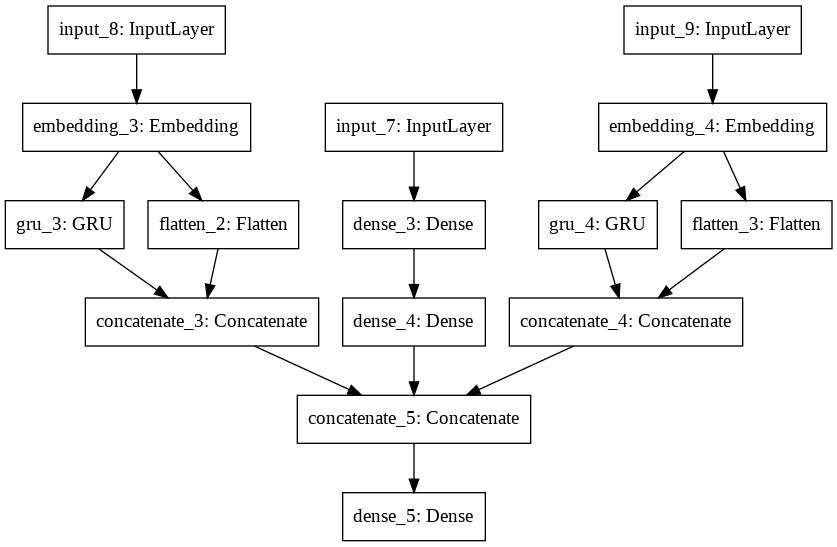

In [ ]:
model = build_model()

print(model.summary())
tf.keras.utils.plot_model(model)

**Training**

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

batch_size = 32
epochs = 3

history = model.fit(
    [X_train, desc_train, tweets_train],
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('./model.h5', save_best_only=True, save_weights_only=True),
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/3
329/329 [==============================] - 252s 755ms/step - loss: 0.8584 - accuracy: 0.5782 - val_loss: 0.7606 - val_accuracy: 0.6483
Epoch 2/3
329/329 [==============================] - 242s 735ms/step - loss: 0.3615 - accuracy: 0.8831 - val_loss: 0.7948 - val_accuracy: 0.6517
Epoch 3/3
329/329 [==============================] - 244s 742ms/step - loss: 0.0949 - accuracy: 0.9793 - val_loss: 0.8568 - val_accuracy: 0.6422


In [ ]:
model.load_weights('./model.h5')

Accuracy


In [ ]:
results = model.evaluate([X_test, desc_test, tweets_test], y_test, verbose=0)
print("Model Accuracy: {:.2f}%".format(results[1] * 100))

Model Accuracy: 64.99%


In [ ]:
y_true = np.array(y_test)

y_pred = model.predict([X_test, desc_test, tweets_test])
y_pred = map(lambda x: np.argmax(x), y_pred)
y_pred = np.array(list(y_pred))

In [ ]:
cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names=['Female', 'Male', 'Brand'])

In [ ]:
print("Classification Report:\n\n", clr)

Classification Report:

               precision    recall  f1-score   support

      Female       0.58      0.77      0.66      2004
        Male       0.59      0.45      0.51      1779
       Brand       0.81      0.71      0.76      1853

    accuracy                           0.65      5636
   macro avg       0.66      0.64      0.64      5636
weighted avg       0.66      0.65      0.65      5636

